In [90]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [91]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
model_path_0 = './presentation/results_old/paper/pretraining/'
model_path_1 = './presentation/results/diagstromer/2024-12-02_14-13-12/pretraining/'
models = []
configs = []
for m in [model_path_0, model_path_1]:
    astromer, config = load_pt_model(m)
    models.append(astromer)
    configs.append(config)

label = ['Astromer v0', 'Astromer v1']

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Adding trainable MSK token


In [94]:
models[0].summary()

Model: "ASTROMER-0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 mask (InputLayer)           [(None, 200, 1)]             0         []                            
                                                                                                  
 times (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 encoder (Encoder)           (None, None, 256)            660736    ['input[0][0]',               
                                                                     'mask[0][0]',       

In [84]:
data = './data/shared/records/atlas/fold_0/atlas/'
batch_size = 16
loaders = build_loader(data, 
                       params=config,
                       batch_size=batch_size, 
                       sampling=True,
                       return_test=False,
                       shuffle=True,
                       probed=0.5,
                       random=0.0,
                       same=0.0,
                       clf_mode=False,
                    )

metadata = pd.read_parquet('./data/raw_parquet/atlas/metadata.parquet')

[INFO] String based loader
[INFO] Changing path:  ./data/shared/records/atlas/fold_0/atlas/val
[INFO] Probed: 0.50 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Cache activated
[INFO] Probed: 0.50 Random: 0.00 Same: 0.00
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows


# Visualizing Attention

In [85]:
from astropy.timeseries import LombScargle

def fold_curve(times, magnitudes):
    frequency, power = LombScargle(times, magnitudes).autopower()
    period = 1/frequency[np.argmax(power)]
    phase = (times % period)/period
    indices = np.argsort(phase)
    return indices

In [86]:
# zz = z[0].numpy()
# plt.figure(dpi=300)
# plt.imshow(np.repeat(zz, 6, axis=1))
# plt.axis('off')
# plt.savefig('./presentation/figures/attention/longvector.png', format='png')

[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


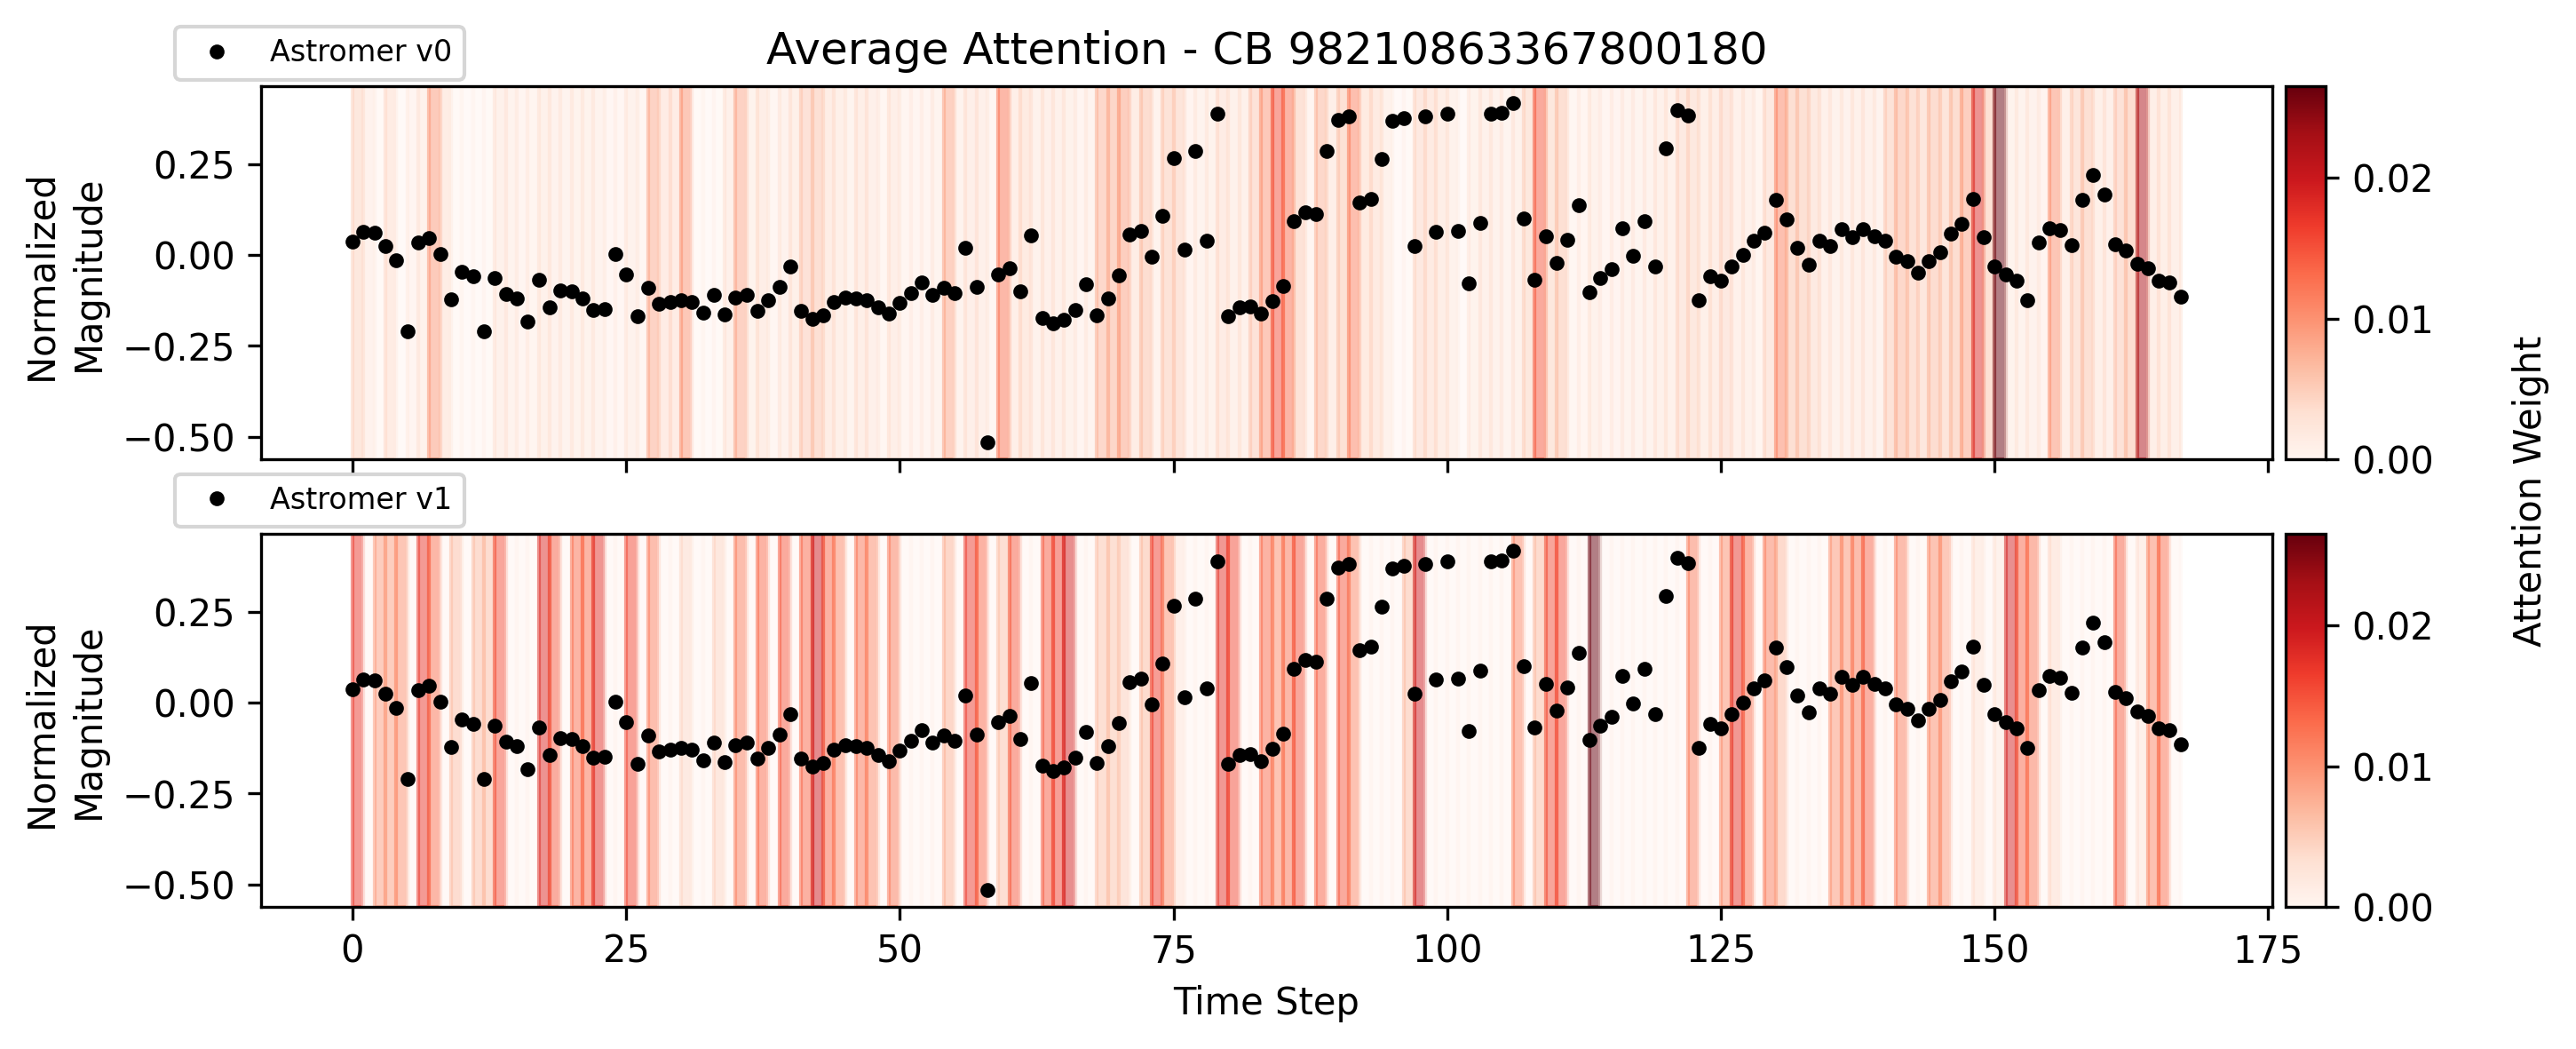

In [89]:
N = 1
attentions = []
magnitudes = []
times      = []

for batch, batch_out in loaders['validation'].skip(300).take(1):
    
    pass
    
        
for m in models:
    encoder = m.get_layer("encoder")
    z, w, qkvalues = encoder(batch, return_weights=True)

    light_curve  = batch['input'][N, :, 0].numpy()
    mask_in      = batch['mask_in'][N, :, 0].numpy()
    times        = batch['times'][N, :, 0].numpy()
    
    att_weigths  = w[N].numpy()
    id_lc = batch_out['lcid'][N].numpy().decode()
    lc_metadata  = metadata[metadata['ID'].astype(str) == str(id_lc)]
    class_name   = lc_metadata['Class'].values[0]
    validindices = np.where(light_curve !=0)[0]
    light_curve  = light_curve[validindices]
    mask_in      = mask_in[validindices]
    times        = times[validindices]
    att_weigths  = att_weigths[:,validindices][..., validindices]

    indices = fold_curve(times, light_curve)

    magnitudes.append(light_curve[indices])
    attentions.append(att_weigths[:, indices])
    
min_values = []
max_values = []
LL = 25
head_n = 0
H = 4
for aw in attentions:
    mean_attention = aw[head_n]
    mean_attention = np.mean(mean_attention[LL-H:LL+H, :], 0)#np.mean(mean_attention, 0)
    max_values.append(mean_attention.max())
    min_values.append(mean_attention.min())

min_att = min(min_values)
max_att = min(max_values)

fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=300, sharex=True, sharey=True)
count = 0

for count in range(len(attentions)):
    aw = attentions[count]
    lc = magnitudes[count]
    mean_attention = aw[head_n]
    # mean_attention = np.mean(aw, 0)
    # mean_attention = np.mean(mean_attention, 0)
    mean_attention = np.mean(mean_attention[LL-H:LL+H, :], 0)

    mean_attention = (mean_attention - mean_attention.min())/(mean_attention.max()-mean_attention.min())
    mean_attention = mean_attention*(max_att-min_att) + min_att
    sequence_length = lc.shape[0]


    # Normalize the attention values for better color scaling (0 to 1)
    norm = plt.Normalize(mean_attention.min(), mean_attention.max())
    axes[count].plot(range(sequence_length), lc, marker='.', linestyle='', color='k', label=label[count])
    
    # Choose a colormap (e.g., viridis, YlOrBr, Blues)
    cmap = plt.cm.Reds
    for i in range(sequence_length - 1):
        rgba_color = cmap(norm(mean_attention[i]))
        # ax.axvspan(times[i], times[i+1], color=rgba_color, alpha=0.5)
        axes[count].axvspan(i, i+1, color=rgba_color, alpha=0.5)
    
    # Add the color bar for attention values
    sm = ScalarMappable(cmap=cmap, norm=norm)  # ScalarMappable to link color mapping
    sm.set_array([])  # Required for color bar but not used directly in plotting

    axes[count].legend(loc='upper left', bbox_to_anchor=(-0.05, 1.2), fontsize=8)
    axes[count].set_ylabel('Normalized \nMagnitude')
    divider = make_axes_locatable(axes[count])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    cbar = plt.colorbar(sm, cax=cax)  # Add color bar to the same axis    
    count+=1

    

fig.text(0.97, 0.5, 'Attention Weight', va='center', rotation='vertical', fontsize=10)

axes[0].set_title('Average Attention - {} {}'.format(class_name, id_lc))
axes[1].set_xlabel('Time Step')

fig.savefig('./presentation/figures/attention/light_curve_att.pdf', bbox_inches='tight')

In [ ]:
# plt.figure(dpi=200)
# plt.imshow(att_weigths[0], cmap='inferno')
# plt.title('Attention Weigths')
# plt.colorbar()
# plt.show()

## Getting Q, K, and V

In [67]:
encoder = models[0].get_layer('encoder')
config = configs[0]
for batch, _ in loaders['train'].take(1):
    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=batch_size)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=batch_size)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=batch_size)

    mask = batch['mask_in']

2024-12-05 02:13:45.341438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Effect of temperature

In [56]:
w = []
temps = [1, 2]#np.arange(0.5, 3, 0.5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.zeros_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [57]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, 10, :]
    attention_vectors.append(master)

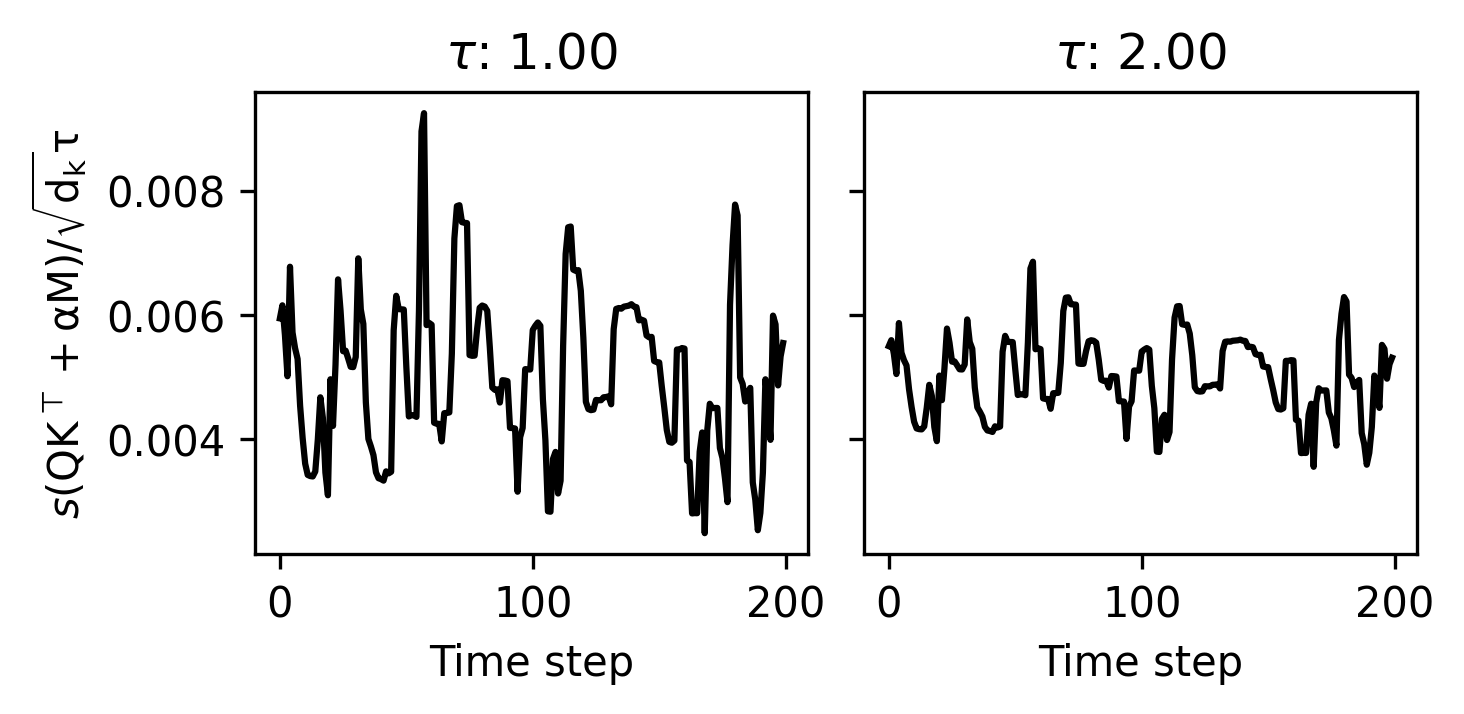

In [59]:
fig, axes = plt.subplots(1, len(temps), figsize=(5,2.), sharey=True, dpi=300, gridspec_kw={'wspace':0.1})

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title(r'$\tau$: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    # axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} +\alpha\rm{M})/\sqrt{d_k}\tau$')
fig.savefig('./presentation/figures/temperature.pdf', format='pdf', bbox_inches='tight')

### Effect of alpha when masking via softmax arg

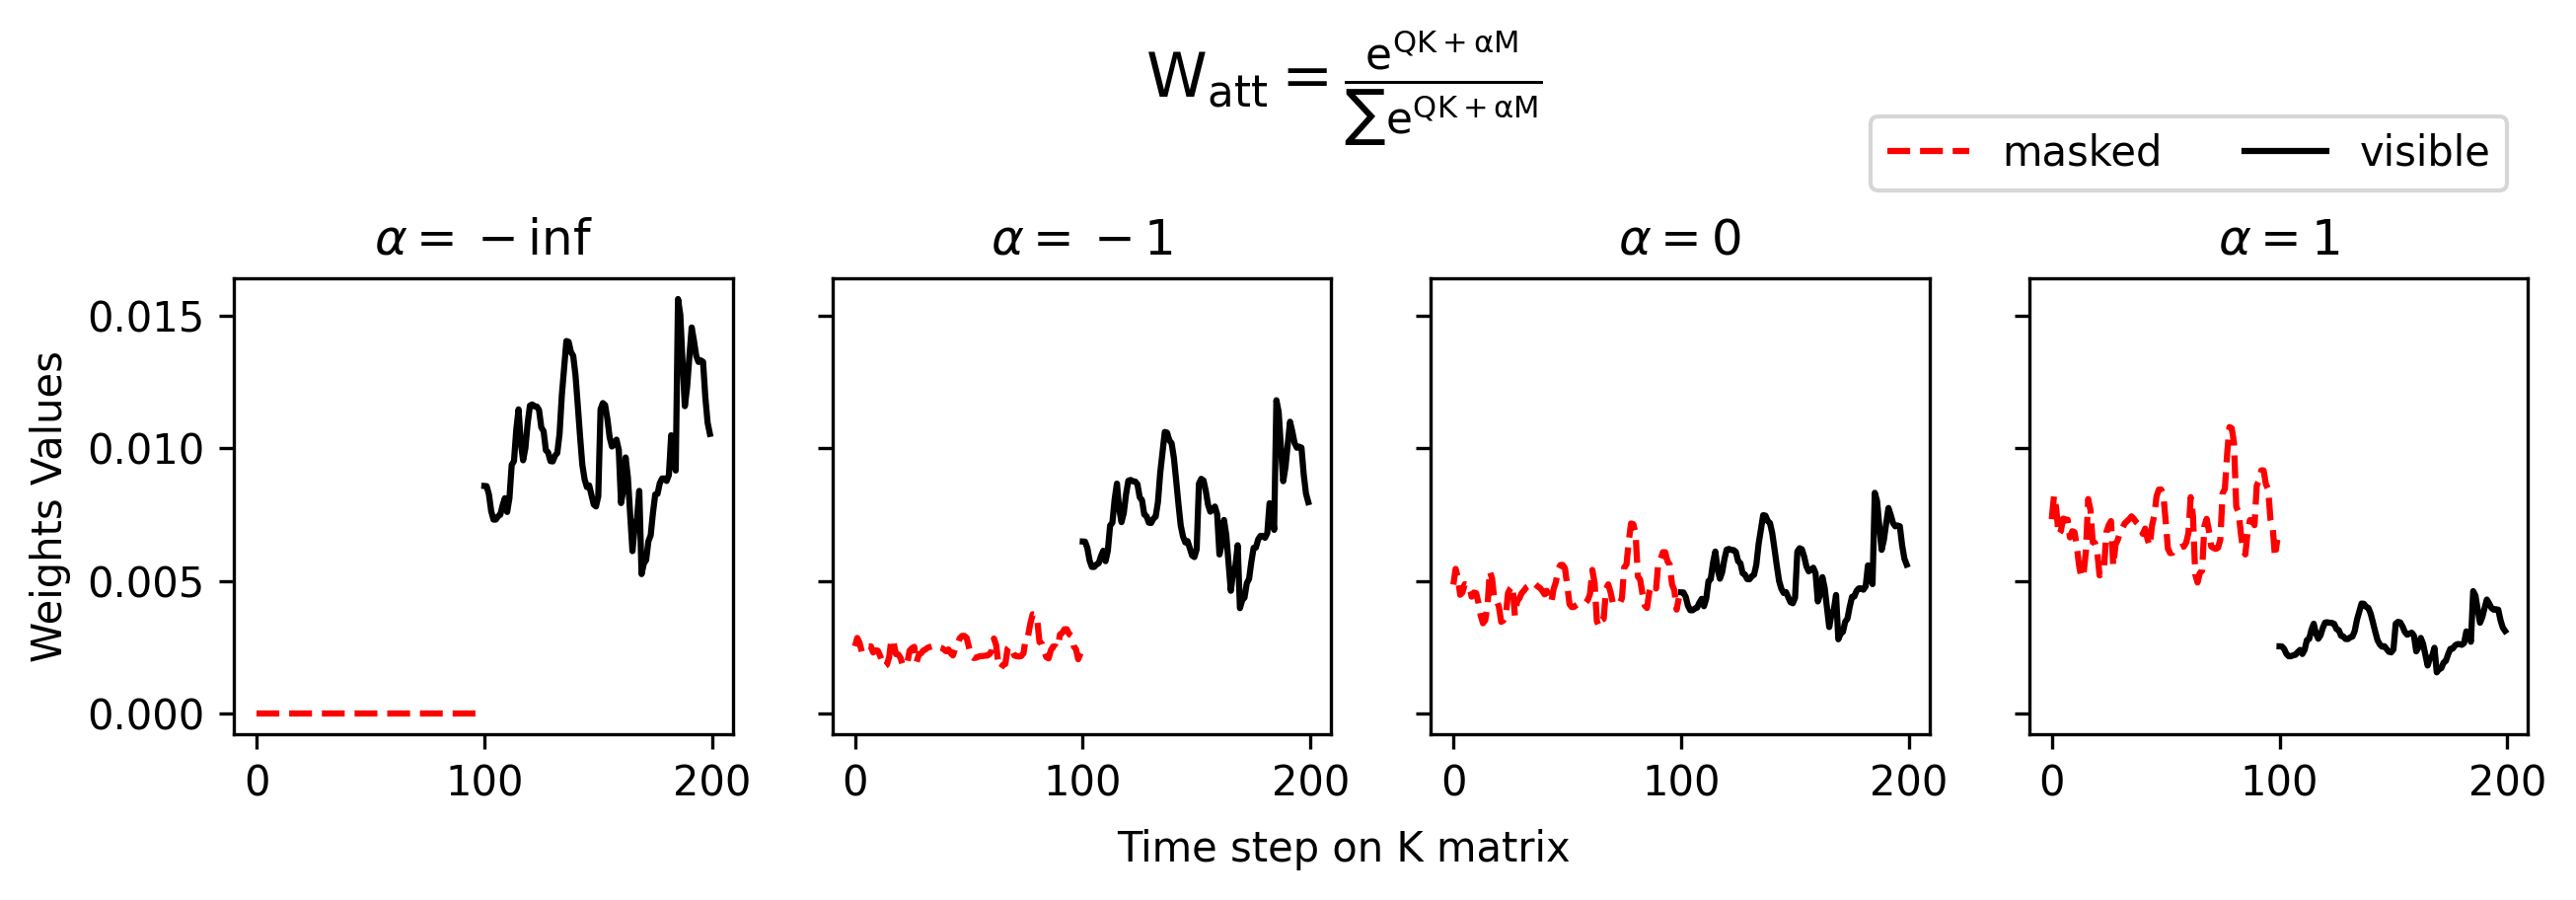

In [30]:
alphas = [-1e9, -1, 0, 1]
labels = [r'$\alpha=-\inf$', r'$\alpha=-1$', r'$\alpha=0$', r'$\alpha=1$']

fig, axes = plt.subplots(1, 4, figsize=(10, 2), dpi=300, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):
    mask_dim = mask.shape
    neg = tf.ones([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    pos = tf.zeros([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    mask_new = tf.concat([neg, pos], 1)
    
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask_new, m_alpha=alp, mask_format='K')


    v = attention_weights[0, 0, 0]

    axes[i].plot(range(0, 100), v[:100], label='masked', color='red', linestyle='--')
    axes[i].plot(range(100, 200), v[100:200], label='visible', color='k')
    axes[i].set_title('{}'.format(labels[i]))
    # axes[i].set_yscale('log')
    # axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])

axes[-1].legend(bbox_to_anchor=(1., 1.4), ncols=2)
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.3,r'$\rm{W}_{att} = \frac{e^{QK + \alpha M}}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)
fig.text(0.5,-0.05,'Time step on K matrix',horizontalalignment='center',
       verticalalignment='top', fontsize=10)
fig.savefig('./presentation/figures/alpha_on_weights.pdf', format='pdf', bbox_inches='tight')
